In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from opendp.mod import binary_search, binary_search_param, enable_features

from tools import *

enable_features('contrib')
enable_features('floating-point')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


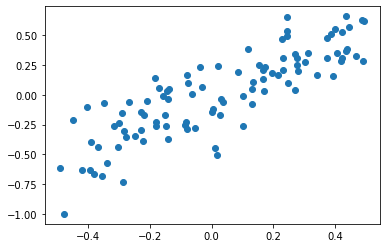

In [ ]:
slope = 1.

x = np.random.uniform(-0.5, 0.5, 100)
y = clamp(slope * x + np.random.normal(loc=0., scale=0.2, size=100), (-1, 1))

plt.scatter(x, y)

In [ ]:
def release_sufficient_statistics(X, y):
    return np.transpose(X) @ X, np.transpose(X) @ y, np.transpose(y) @ y

def release_dp_sufficient_statistics(X, y, epsilon, X_bounds, y_bounds, d=1):
    w_x = X_bounds[1] - X_bounds[0]
    w_y = y_bounds[1] - y_bounds[0]
    noise_scale = w_x ** 2 * d * (d+1)/2 + w_x * w_y * d + w_y ** 2
    return np.transpose(X) @ X + laplace(scale=noise_scale/epsilon), np.transpose(X) @ y + laplace(scale=noise_scale/epsilon), np.transpose(y) @ y + laplace(scale=noise_scale/epsilon)

# let's restrict to an exceedingly simple case: known variance
# then try 1D case with unknown variance (in paper)

In [ ]:
def bayes_fixed_variance(X, y, prior, sigma):
    prior_mean, prior_var = prior
    s1, s2, s3 = release_sufficient_statistics(X, y)
    # only considering 1D
    posterior_mean = 1/(1/prior_var + s1) * (1/prior_var * prior_mean + s2)
    posterior_var = sigma**2 * 1/(1/prior_var + s1)
    return posterior_mean, posterior_var

def dp_bayes_fixed_variance(X, y, prior, sigma, epsilon, dim=1, X_bounds=(-1., 1.), y_bounds=(-1., 1.)):
    prior_mean, prior_var = prior
    s1, s2, s3 = release_dp_sufficient_statistics(X, y, epsilon, X_bounds, y_bounds, dim)
    # only considering 1D
    posterior_mean = 1/(1/prior_var + s1) * (1/prior_var * prior_mean + s2)
    posterior_var = sigma**2 * 1/(1/prior_var + s1)
    return posterior_mean, posterior_var

def dp_bayes(X, y, prior, epsilon, dim=1, X_bounds=(-1., 1.), y_bounds=(-1., 1.)):
    # need to work in inverse gamma prior/posterior
    pass

In [ ]:
def ols_regression(x, y):
    s_xy = np.sum(x * y)
    s_xx = np.sum(x ** 2)
    return s_xy / s_xx

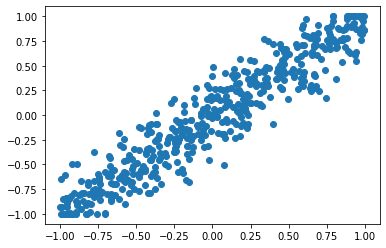

In [ ]:
variance = 0.2
sigma = np.sqrt(variance)
N = 500
epsilon = 1.

x = np.random.uniform(-1., 1., N)
y = clamp(slope * x + np.random.normal(loc=0., scale=variance, size=N), (-1, 1))

plt.scatter(x, y)

0.9548361952674717 0.0012480995339771907
1.0934422703798141 0.0013792256605354098


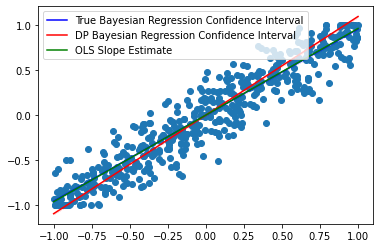

In [ ]:
prior = (0., 1.)
posterior_mean, posterior_var = bayes_fixed_variance(x, y, prior, sigma)
dp_posterior_mean, dp_posterior_var = dp_bayes_fixed_variance(x, y, prior, sigma, epsilon)

print(posterior_mean, posterior_var)
print(dp_posterior_mean, dp_posterior_var)

range_x = np.array([-1] + list(x) + [1])

fig, ax = plt.subplots()
ci = posterior_var * 1.96
dp_ci = dp_posterior_var * 1.96
posterior_y = posterior_mean * range_x
dp_posterior_y = dp_posterior_mean * range_x

ols_slope = ols_regression(x, y)
ax.scatter(x, y)
ax.plot(range_x, posterior_y, color="b", label="True Bayesian Regression Confidence Interval")
ax.fill_between(range_x, (posterior_mean-ci)*range_x, (posterior_mean+ci)*range_x, color='b', alpha=.1)
ax.plot(range_x, dp_posterior_y, color="r", label="DP Bayesian Regression Confidence Interval")
ax.fill_between(range_x, (dp_posterior_mean-dp_ci)*range_x, (dp_posterior_mean+dp_ci)*range_x, color='r', alpha=.1)
ax.plot(range_x, ols_slope * range_x, color="g", label="OLS Slope Estimate")
plt.legend()
plt.show()


In [ ]:
print(posterior_mean - ols_slope)

-0.005996071522051061


In [ ]:
N = 500
trials = 100
slope = 1.

bayes_sd, bayes_bias = [], []
dp_bayes_sd, dp_bayes_bias = [], []

epsilons = np.logspace(-1, 1, 50)

for epsilon in epsilons:
    slopes, biases = [], []
    dp_slopes, dp_biases = [], []

    for _ in range(trials):
        x = np.random.uniform(-1., 1., N)
        y = clamp(slope * x + np.random.normal(loc=0., scale=0.5, size=N), (-1, 1))
        ols_slope = ols_regression(x, y)
        posterior_mean, _ = bayes_fixed_variance(x, y, prior, sigma)
        dp_posterior_mean, _ = dp_bayes_fixed_variance(x, y, prior, sigma, epsilon)

        biases.append(posterior_mean - ols_slope)
        dp_biases.append(dp_posterior_mean - ols_slope)
        slopes.append(posterior_mean)
        dp_slopes.append(dp_posterior_mean)
        
    bayes_sd.append(np.std(slopes))
    dp_bayes_sd.append(np.std(dp_slopes))
    bayes_bias.append(np.mean(biases))
    dp_bayes_bias.append(np.mean(dp_biases))


ValueError: x and y must have same first dimension, but have shapes (50,) and (70,)

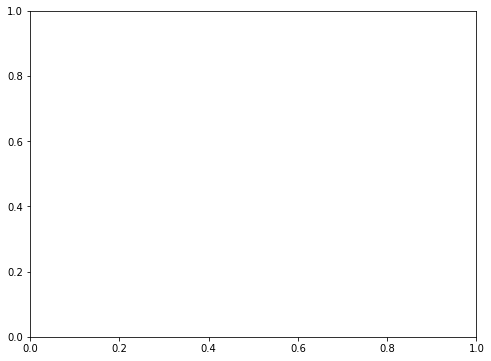

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(np.logspace(-1, 1, 50), bayes_sd, color="green", label="Average Non-Private Bayes Standard Deviation")
plt.plot(np.logspace(-1, 1, 50), bayes_bias, color="blue", label="Average Non-Private Bayes Bias vs. OLS")
plt.plot(np.logspace(-1, 1, 50), dp_bayes_sd, color="red", label="Average DP Bayes Standard Deviation")
plt.plot(np.logspace(-1, 1, 50), dp_bayes_bias, color="black", label="Average DP Bayes Bias vs. OLS")

# plt.xlabel("σ²")
plt.xlabel("ε")
# plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Bayes and DP Bayes Posterior Means")
plt.legend()
plt.show()

In [ ]:
trials = 100
epsilon = 1.
slope = 1.

bayes_sd, bayes_bias = [], []
dp_bayes_sd, dp_bayes_bias = [], []

Ns = np.arange(50, 1000, 10)

for N in Ns:
    slopes, biases = [], []
    dp_slopes, dp_biases = [], []

    for _ in range(trials):
        x = np.random.uniform(-1., 1., N)
        y = clamp(slope * x + np.random.normal(loc=0., scale=0.5, size=N), (-1, 1))
        ols_slope = ols_regression(x, y)
        posterior_mean, _ = bayes_fixed_variance(x, y, prior, sigma)
        dp_posterior_mean, _ = dp_bayes_fixed_variance(x, y, prior, sigma, epsilon)

        biases.append(posterior_mean - ols_slope)
        dp_biases.append(dp_posterior_mean - ols_slope)
        slopes.append(posterior_mean)
        dp_slopes.append(dp_posterior_mean)
        
    bayes_sd.append(np.std(slopes))
    dp_bayes_sd.append(np.std(dp_slopes))
    bayes_bias.append(np.mean(biases))
    dp_bayes_bias.append(np.mean(dp_biases))


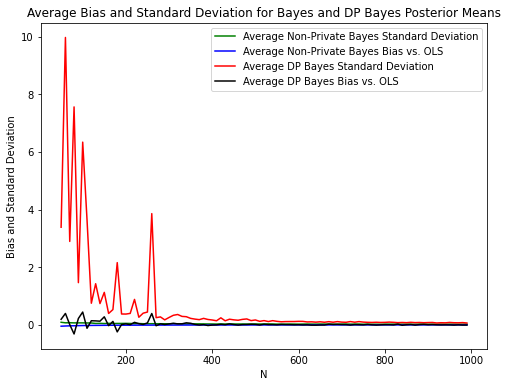

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(Ns, bayes_sd, color="green", label="Average Non-Private Bayes Standard Deviation")
plt.plot(Ns, bayes_bias, color="blue", label="Average Non-Private Bayes Bias vs. OLS")
plt.plot(Ns, dp_bayes_sd, color="red", label="Average DP Bayes Standard Deviation")
plt.plot(Ns, dp_bayes_bias, color="black", label="Average DP Bayes Bias vs. OLS")

# plt.xlabel("σ²")
plt.xlabel("N")
# plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Bayes and DP Bayes Posterior Means")
plt.legend()
plt.show()

In [ ]:
trials = 100
epsilon = 1.
slope = 1.
N = 500

bayes_sd, bayes_bias = [], []
dp_bayes_sd, dp_bayes_bias = [], []

sigmas = np.arange(0.05, 0.75, 0.01)

for sigma in sigmas:
    slopes, biases = [], []
    dp_slopes, dp_biases = [], []

    for _ in range(trials):
        x = np.random.uniform(-1., 1., N)
        y = clamp(slope * x + np.random.normal(loc=0., scale=sigma, size=N), (-1, 1))
        ols_slope = ols_regression(x, y)
        posterior_mean, _ = bayes_fixed_variance(x, y, prior, sigma)
        dp_posterior_mean, _ = dp_bayes_fixed_variance(x, y, prior, sigma, epsilon)

        biases.append(posterior_mean - ols_slope)
        dp_biases.append(dp_posterior_mean - ols_slope)
        slopes.append(posterior_mean)
        dp_slopes.append(dp_posterior_mean)
        
    bayes_sd.append(np.std(slopes))
    dp_bayes_sd.append(np.std(dp_slopes))
    bayes_bias.append(np.mean(biases))
    dp_bayes_bias.append(np.mean(dp_biases))


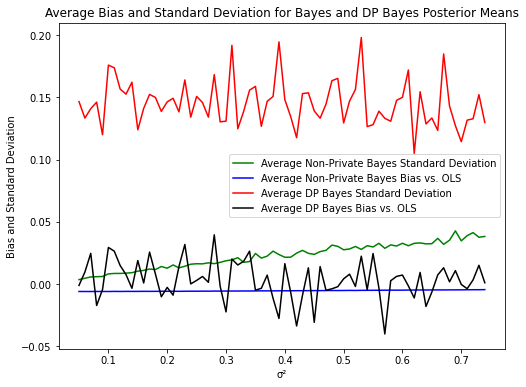

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(sigmas, bayes_sd, color="green", label="Average Non-Private Bayes Standard Deviation")
plt.plot(sigmas, bayes_bias, color="blue", label="Average Non-Private Bayes Bias vs. OLS")
plt.plot(sigmas, dp_bayes_sd, color="red", label="Average DP Bayes Standard Deviation")
plt.plot(sigmas, dp_bayes_bias, color="black", label="Average DP Bayes Bias vs. OLS")

plt.xlabel("σ²")
# plt.xlabel("N")
# plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Bayes and DP Bayes Posterior Means")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d71c9c3-da98-48cf-bf84-cbaf5507821e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>